# Notebook to generate decodability plots

In [43]:
"""Imports."""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [44]:
"""Load results."""

BASE_RESULTS_DIR = Path("../../../cache/figures/supp_fig_decoding")
DATASETS = ["1_triangle", "2_triangle_complement"]


def _get_test_decodability(seed_dir):
    test_targets = np.load(seed_dir / "test_targets.npy")
    test_outputs = np.load(seed_dir / "test_outputs.npy")
    pred_indices = np.argmax(test_outputs, axis=-1)
    true_indices = np.argmax(test_targets, axis=-1)
    decodability = 100 * float(np.mean(pred_indices == true_indices))
    return decodability

results_df = {
    "dataset": [],
    "brain_area": [],
    "feature": [],
    "mode": [],
    "subject": [],
    "session": [],
    "phase": [],
    "seed": [],
    "Decodability %": [],
}

for dataset in DATASETS:
    for feature in ["position", "identity"]:
        id_dir = BASE_RESULTS_DIR / dataset / f"feature={feature}"
        for brain_area_dir in id_dir.iterdir():
            brain_area = brain_area_dir.name
            for subject_session_dir in brain_area_dir.iterdir():
                subject = subject_session_dir.stem.split("_")[0]
                session = subject_session_dir.stem.split("_")[1]
                if session not in ["2022-06-01", "2022-06-04", "2022-05-31"]:
                    continue
                for phase_dir in subject_session_dir.iterdir():
                    phase = phase_dir.name
                    for shuffle_labels in [False, True]:
                        shuffle_dir = phase_dir / f"shuffle_labels={int(shuffle_labels)}"
                        mode = "Null" if shuffle_labels else "Neural"
                        for seed_dir in shuffle_dir.iterdir():
                            seed = int(seed_dir.name)
                            decodability = _get_test_decodability(seed_dir)
                            results_df["dataset"].append(dataset)
                            results_df["brain_area"].append(brain_area)
                            results_df["feature"].append(feature)
                            results_df["mode"].append(mode)
                            results_df["subject"].append("Perle")
                            results_df["session"].append(session)
                            results_df["phase"].append(phase.capitalize())
                            results_df["seed"].append(seed)
                            results_df["Decodability %"].append(decodability)
results_df = pd.DataFrame(results_df)

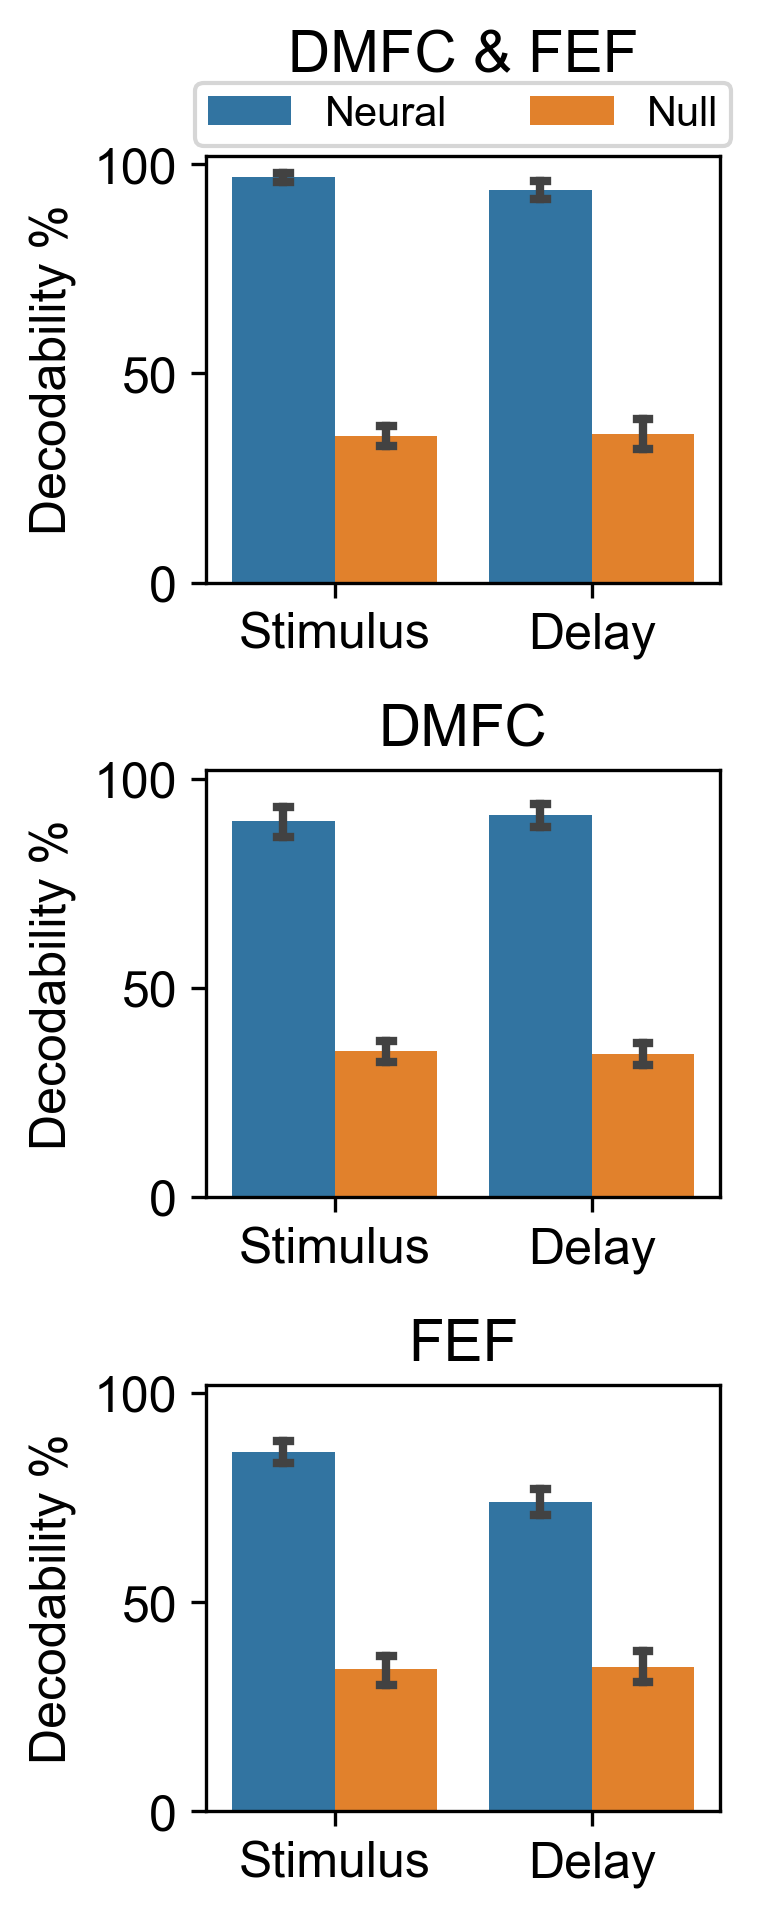

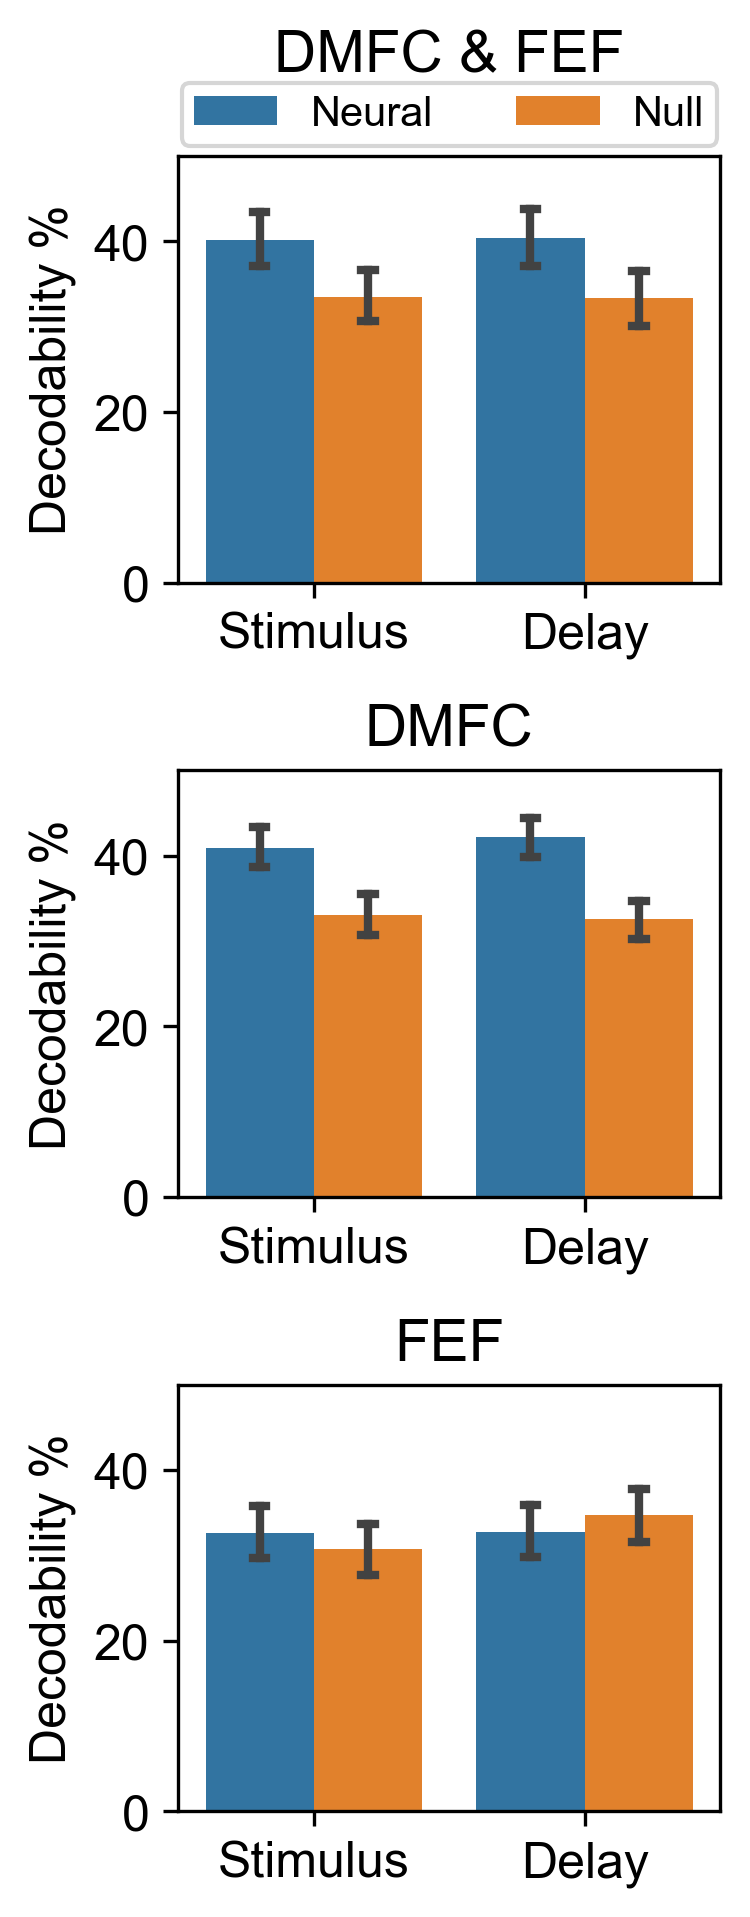

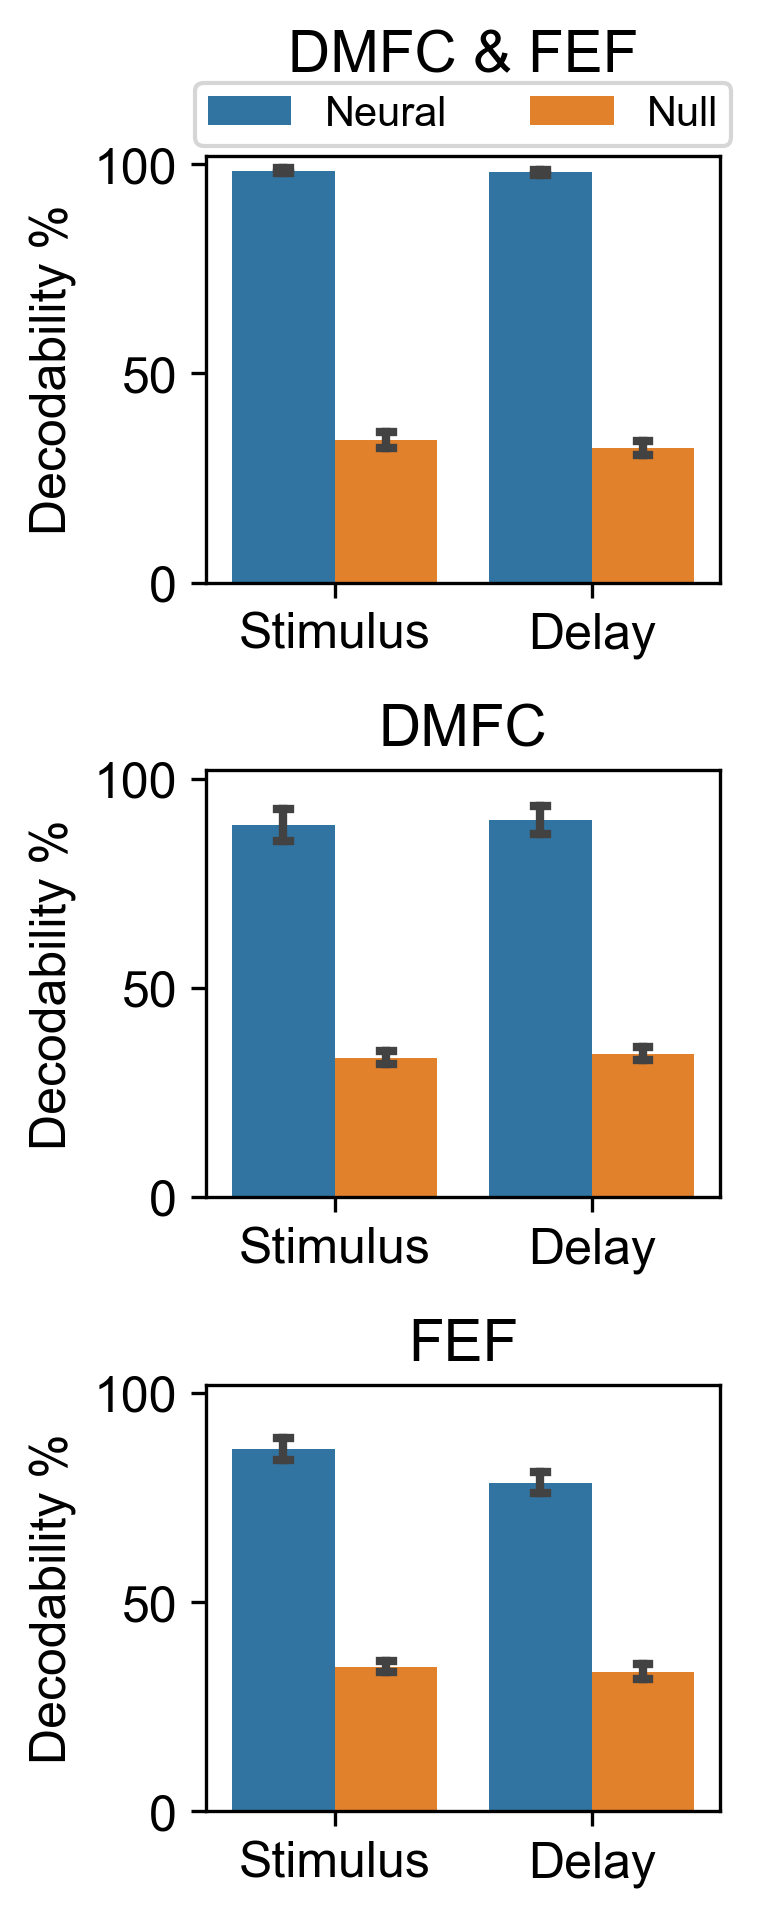

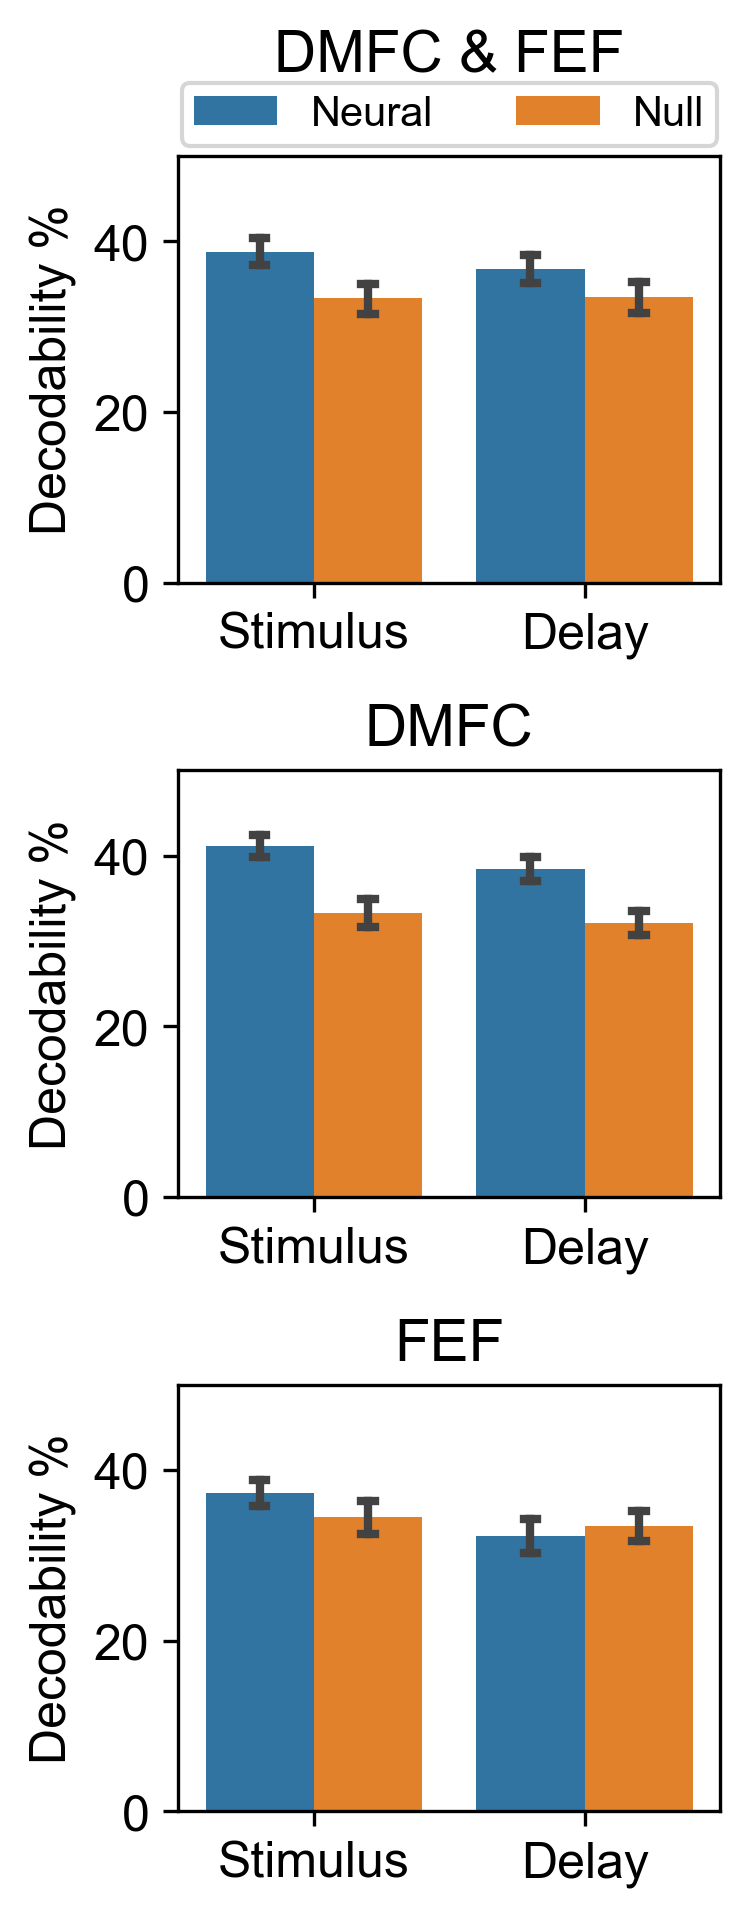

In [45]:
"""Plot results."""

for dataset in DATASETS:
    for feature in ["position", "identity"]:
        subset_df = results_df[
            (results_df["dataset"] == dataset)
            & (results_df["feature"] == feature)
        ]
        fig, axes = plt.subplots(3, 1, figsize=(2.6, 6.5))
        for ax, brain_area in zip(axes, ["None", "DMFC", "FEF"]):
            if brain_area == "None":
                brain_area_str = "DMFC & FEF"
                legend = True
            else:
                brain_area_str = brain_area
                legend = False
            sns.barplot(
                data=subset_df[subset_df["brain_area"] == brain_area],
                x="phase",
                hue="mode",
                y="Decodability %",
                ax=ax,
                err_kws={"linewidth": 2},
                capsize=0.1,
                legend=legend,
            )
            y_title = 1.14 if legend else 1.
            ax.set_title(brain_area_str, y=y_title)
            if feature == "position":
                ax.set_ylim(0, 102)
            else:
                ax.set_ylim(0, 50)
            ax.set_ylabel(
                "Decodability %",
                # labelpad=-2,
            )
            ax.set_xlabel("")
            if legend:
                ax.legend(
                    loc="upper center",
                    bbox_to_anchor=(0.5, 1.22),
                    ncol=2,
                    # columnspacing=1,
                    # handlelength=1.5,
                    borderpad=0.3,
                )
        plt.tight_layout()
        fig.savefig(f"./{dataset}_{feature}_decodability.pdf", bbox_inches="tight", pad_inches=0.01)